In [102]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from TA import *
import ccxt
from datetime import datetime, timedelta

# 1. Data Acquisition
def create_raw_stock_dataset(symbol, time_interval, start_date):
    """Fetch OHLCV data from Binance using CCXT."""
    exchange = ccxt.binance()
    since = int(start_date.timestamp() * 1000)
    ohlcv = exchange.fetch_ohlcv(symbol, time_interval, since=since, limit=10000)
    data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    data.set_index('timestamp', inplace=True)
    return data

def fetch_data(symbol, time_interval, start_date, end_date=None):
    """Fetch data using create_raw_stock_dataset and handle pagination if needed."""
    start = pd.to_datetime(start_date)
    
    # Initial data fetch
    data = create_raw_stock_dataset(symbol, time_interval, start)
    
    # If end_date is specified and more data is needed, fetch in chunks
    if end_date is not None:
        end = pd.to_datetime(end_date)
        current_end = data.index[-1]
        
        # Continue fetching until we reach end_date or no more data
        while current_end < end and len(data) > 0:
            # Next fetch starts from the last timestamp + 1ms
            next_start = current_end + pd.Timedelta(milliseconds=1)
            next_data = create_raw_stock_dataset(symbol, time_interval, next_start)
            
            # Break if no new data
            if len(next_data) == 0:
                break
                
            # Append new data and update current end
            data = pd.concat([data, next_data])
            current_end = data.index[-1]
    
    # Ensure column names match expected format (capitalized first letter)
    data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    # Filter by end_date if specified
    if end_date is not None:
        data = data[data.index <= end_date]
    
    return data

In [103]:
def engineer_features(df):
    """Generate technical indicators and other features."""
    # Make a copy to avoid SettingWithCopyWarning
    data = df.copy()
    
    # Technical Indicators
    # Momentum indicators
    # RSI
    data['RSI'] = calculate_rsi(data['Close'], 14)

    # MACD
    data['MACD'], data['MACD_Signal'], data['MACD_Hist'] = calculate_macd(data['Close'])

    # stochastic
    data['Stoch_K'], data['Stoch_D'] = calculate_stoch(data)

    # Simple Moving Averages
    data['SMA20'] = data['Close'].rolling(window=20).mean()
    data['SMA50'] = data['Close'].rolling(window=50).mean()
    data['SMA200'] = data['Close'].shift(1).rolling(200).mean()

    # Exponential Moving Average
    data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()

    # ADX
    data['ADX'] = calculate_adx(data.shift(1))

    # ATR
    data['ATR'] = calculate_atr(data)

    # Bollinger Bands
    data['BB_Upper'], data['BB_Middle'], data['BB_Lower'] = calculate_bbands(data)
    data['BB_Width'] = (data['BB_Upper'] - data['BB_Lower']) / data['BB_Middle']

    # OBV
    data['OBV'] = calculate_obv(data)
    
    # Calculate VWAP manually
    data['Typical_Price'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['VP'] = data['Typical_Price'] * data['Volume']
    data['VWAP'] = data['VP'].rolling(window=20).sum() / data['Volume'].rolling(window=20).sum()
    
    # Time features
    data['Day_of_Week'] = data.index.dayofweek
    data['Hour'] = data.index.hour  # Useful for intraday data
    data['Month'] = data.index.month
    data['Quarter'] = data.index.quarter
    
    # Lag features
    for lag in [1, 3, 7]:
        data[f'Return_Lag_{lag}'] = data['Close'].pct_change(lag)
    
    # Rolling statistics
    for window in [7, 30]:
        data[f'Std_Dev_{window}D'] = data['Close'].rolling(window=window).std()
        data[f'MA_{window}D'] = data['Close'].rolling(window=window).mean()
        data[f'Z_Score_{window}D'] = (data['Close'] - data[f'MA_{window}D']) / data[f'Std_Dev_{window}D']
    
    # Price relative to moving averages
    data['Close_Rel_SMA20'] = data['Close'] / data['SMA20'] - 1
    data['Close_Rel_SMA50'] = data['Close'] / data['SMA50'] - 1
    data['Close_Rel_SMA200'] = data['Close'] / data['SMA200'] - 1
    
    # Crossover signals
    data['SMA20_Cross_SMA50'] = (data['SMA20'] > data['SMA50']).astype(int)
    
    # Additional features
    data['High_Low_Range'] = data['High'] - data['Low']
    data['Close_Open_Range'] = abs(data['Close'] - data['Open'])
    data['Range_Ratio'] = data['Close_Open_Range'] / data['High_Low_Range']
    
    # Cryptocurrency-specific indicators
    # Logarithmic returns may work better for highly volatile assets
    data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))
    
    # Volatility measures
    data['Volatility_30D'] = data['Log_Return'].rolling(window=30).std() * np.sqrt(30)
    
    # Drop rows with NaN values after feature engineering
    data = data.dropna()
    
    return data

In [104]:
def create_target_variable(df, prediction_horizon=5, threshold=0.01):
    """Create target variables for both regression and classification."""
    # Future returns for regression
    df[f'Future_Return_{prediction_horizon}D'] = df['Close'].pct_change(prediction_horizon).shift(-prediction_horizon)
    
    # Binary target for classification
    df[f'Target_Binary_{prediction_horizon}D'] = (df[f'Future_Return_{prediction_horizon}D'] > threshold).astype(int)
    
    # Drop NaN values in target
    df = df.dropna(subset=[f'Future_Return_{prediction_horizon}D'])
    
    return df

def prepare_features_targets(df, prediction_horizon=5, classification=False):
    """Prepare features and target for modeling."""
    # Define target
    if classification:
        target_col = f'Target_Binary_{prediction_horizon}D'
    else:
        target_col = f'Future_Return_{prediction_horizon}D'
    
    # Drop irrelevant columns
    feature_cols = df.columns.difference(['Open', 'High', 'Low', 'Close', 'Volume', 
                                         'Typical_Price', 'VP', 
                                         f'Future_Return_{prediction_horizon}D', 
                                         f'Target_Binary_{prediction_horizon}D'])
    
    X = df[feature_cols]
    y = df[target_col]
    
    return X, y

In [105]:
# 2. TEMPORAL VALIDATION SETUP

def split_data_temporal(df, train_end_date, valid_end_date):
    """Split data into training, validation, and test sets preserving temporal order."""
    train_data = df[df.index <= train_end_date]
    valid_data = df[(df.index > train_end_date) & (df.index <= valid_end_date)] 
    test_data = df[df.index > valid_end_date]
    
    return train_data, valid_data, test_data

def walk_forward_validation(df, start_date, end_date, step_size='15D', prediction_horizon=5, classification=False):
    """Implement walk-forward validation."""
    current_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    results = []
    
    while current_date < end_date:
        # Define validation end date
        valid_end_date = current_date
        
        # Define training end date (one step before validation)
        if step_size.endswith('M'):
            months = int(step_size[:-1])
            train_end_date = (current_date - pd.DateOffset(months=months))
        elif step_size.endswith('D'):
            days = int(step_size[:-1])
            train_end_date = (current_date - pd.DateOffset(days=days))
        
        # Split data
        train_data, valid_data, _ = split_data_temporal(df, train_end_date, valid_end_date)
        
        if len(valid_data) > 0:  # Skip if no validation data
            # Prepare features and targets
            X_train, y_train = prepare_features_targets(train_data, prediction_horizon, classification)
            X_valid, y_valid = prepare_features_targets(valid_data, prediction_horizon, classification)
            
            # Train model
            model = train_xgboost_model(X_train, y_train, X_valid, y_valid, classification)
            
            # Evaluate
            valid_predictions = model.predict(xgb.DMatrix(X_valid))
            
            if classification:
                score = accuracy_score(y_valid, (valid_predictions > 0.5).astype(int))
                metric_name = 'Accuracy'
            else:
                score = mean_squared_error(y_valid, valid_predictions, squared=False)
                metric_name = 'RMSE'
            
            results.append({
                'Train_End_Date': train_end_date,
                'Valid_End_Date': valid_end_date,
                metric_name: score
            })
        
        # Move to next step
        if step_size.endswith('M'):
            months = int(step_size[:-1])
            current_date = current_date + pd.DateOffset(months=months)
        elif step_size.endswith('D'):
            days = int(step_size[:-1])
            current_date = current_date + pd.DateOffset(days=days)
    
    return pd.DataFrame(results)

In [106]:
# 3. MODEL DEVELOPMENT

def train_xgboost_model(X_train, y_train, X_valid=None, y_valid=None, classification=False, params=None):
    # Set default parameters
    if params is None:
        params = {
            'objective': 'binary:logistic' if classification else 'reg:squarederror',
            'n_estimators': 1000,
            'learning_rate': 0.05,
            'max_depth': 5,
            'subsample': 0.9,
            'colsample_bytree': 0.7,
            'reg_alpha': 0.1,
            'reg_lambda': 1.0,
            'random_state': 42,
            'eval_metric': 'logloss' if classification else 'rmse',
            'early_stopping_rounds': 100  # Key difference: defined in constructor
        }
    
    # Initialize model with ALL parameters
    model = XGBClassifier(**params) if classification else XGBRegressor(**params)
    
    # Fit with only required arguments
    if X_valid is not None and y_valid is not None:
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=10
        )
    else:
        model.fit(X_train, y_train)
    
    return model

def analyze_feature_importance(model, X_train):
    """Analyze feature importance using sklearn API XGBoost model."""
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)

    # Plot the feature importance
    plt.figure(figsize=(10, 12))
    importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False, color='skyblue')
    plt.title('Feature Importance')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

    return importance_df

def select_features(X_train, feature_importance, top_n=20):
    """Select top N features based on importance."""
    top_features = feature_importance.head(top_n)['Feature'].tolist()
    X_train_selected = X_train[top_features]
    return X_train_selected, top_features

In [107]:
# 4. TRADING STRATEGY INTEGRATION

def generate_signals(predictions, threshold=0.01, classification=False):
    """Generate trading signals based on predictions."""
    if classification:
        # For classification, use probability thresholds
        signals = np.zeros_like(predictions)
        signals[predictions > 0.6] = 1  # Buy signal
        signals[predictions < 0.4] = -1  # Sell signal
    else:
        # For regression, use return thresholds
        signals = np.zeros_like(predictions)
        signals[predictions > threshold] = 1  # Buy signal
        signals[predictions < -threshold] = -1  # Sell signal

     # Logging signal distribution
    print(f"Generated {np.sum(signals == 1)} buy signals, {np.sum(signals == -1)} sell signals, {np.sum(signals == 0)} holds")
    
    return signals

def calculate_position_sizes(signals, prices, atr, volatility_scale=0.005, max_position=0.5):
    """Calculate position sizes using volatility scaling."""
    # Base position sizing on ATR (volatility)
    position_sizes = np.zeros_like(signals, dtype=float)
    
    # Only calculate for non-zero signals
    mask = signals != 0
    
    # Volatility scaling: higher volatility = smaller position
    position_sizes[mask] = volatility_scale / atr[mask]
    
    # Cap at maximum position size
    position_sizes = np.minimum(position_sizes, max_position)
    
    # Apply signal direction
    position_sizes = position_sizes * signals
    
    return position_sizes

def apply_stop_loss(positions, prices, atr, multiplier=2.0):
    """Apply stop loss based on ATR."""
    updated_positions = positions.copy()
    current_position = 0
    stop_level = None
    
    for i in range(1, len(positions)):
        # Update position if there's a new signal
        if positions[i] != 0:
            current_position = positions[i]
            
            # Set stop loss level
            if current_position > 0:  # Long position
                stop_level = prices[i] - multiplier * atr[i]
            elif current_position < 0:  # Short position
                stop_level = prices[i] + multiplier * atr[i]
        
        # Check if stop loss is triggered
        if current_position > 0 and prices[i] < stop_level:  # Long position stop
            updated_positions[i] = 0
            current_position = 0
            stop_level = None
        elif current_position < 0 and prices[i] > stop_level:  # Short position stop
            updated_positions[i] = 0
            current_position = 0
            stop_level = None
        else:
            updated_positions[i] = current_position
    
    return updated_positions

In [108]:
def backtest_strategy(df, signals, holding_period=5, transaction_cost=0.0025):
    """Backtest strategy with signals and fixed holding period."""
    backtest_df = df.copy()
    backtest_df['Signal'] = signals
    backtest_df['Position'] = 0

    # Apply fixed holding period
    for i in range(len(backtest_df)):
        if backtest_df['Signal'].iloc[i] != 0:
            position_idx = backtest_df.columns.get_loc('Position')
            backtest_df.iloc[i:i+holding_period, position_idx] = backtest_df['Signal'].iloc[i]

    backtest_df['Position'] = backtest_df['Position'].shift(1).fillna(0)
    backtest_df['Position_Change'] = backtest_df['Position'].diff().fillna(backtest_df['Position'])

    # Calculate returns
    backtest_df['Market_Return'] = backtest_df['Close'].pct_change()
    backtest_df['Strategy_Return_Raw'] = backtest_df['Position'] * backtest_df['Market_Return']

    # Apply transaction cost on position change
    backtest_df['Transaction_Cost'] = abs(backtest_df['Position_Change']) * transaction_cost
    backtest_df['Strategy_Return'] = backtest_df['Strategy_Return_Raw'] - backtest_df['Transaction_Cost']

    # Cumulative returns
    backtest_df['Cumulative_Market_Return'] = (1 + backtest_df['Market_Return']).cumprod() - 1
    backtest_df['Cumulative_Strategy_Return'] = (1 + backtest_df['Strategy_Return']).cumprod() - 1

    return backtest_df


def calculate_performance_metrics(backtest_df):
    """Calculate various performance metrics for the strategy."""
    # Filter out rows with NaN returns
    filtered_df = backtest_df.dropna(subset=['Strategy_Return'])
    
    # Ensure datetime index and sort
    filtered_df = filtered_df.sort_index()
    assert pd.api.types.is_datetime64_any_dtype(filtered_df.index), "Index must be datetime"
    
    # Calculate time period in years
    start_date = filtered_df.index[0]
    end_date = filtered_df.index[-1]
    period_days = (end_date - start_date).days
    period_years = period_days / 365
    
    # Prevent annualization blow-up for very short periods
    if period_years == 0:
        period_years = 1 / 365  # Assume at least 1 day

    # Return metrics
    total_return = filtered_df['Cumulative_Strategy_Return'].iloc[-1]
    market_return = filtered_df['Cumulative_Market_Return'].iloc[-1]
    annual_return = (1 + total_return) ** (1 / period_years) - 1
    annual_market_return = (1 + market_return) ** (1 / period_years) - 1

    # Volatility and risk metrics
    daily_volatility = filtered_df['Strategy_Return'].std()
    annual_volatility = daily_volatility * (365 ** 0.5)  # Use 365 for crypto

    sharpe_ratio = annual_return / annual_volatility if annual_volatility != 0 else 0

    # Drawdown analysis
    cumulative_returns = (1 + filtered_df['Strategy_Return']).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns / running_max) - 1
    max_drawdown = drawdown.min()

    # Win rate
    win_rate = (filtered_df['Strategy_Return'] > 0).mean()

    # Profit factor
    gross_profits = filtered_df.loc[filtered_df['Strategy_Return'] > 0, 'Strategy_Return'].sum()
    gross_losses = abs(filtered_df.loc[filtered_df['Strategy_Return'] < 0, 'Strategy_Return'].sum())
    profit_factor = gross_profits / gross_losses if gross_losses != 0 else float('inf')

    # Number of trades
    num_trades = (filtered_df['Position_Change'] != 0).sum() if 'Position_Change' in filtered_df else None

    metrics = {
        'Total Return': total_return,
        'Market Return': market_return,
        'Annual Return': annual_return,
        'Annual Market Return': annual_market_return,
        'Annual Volatility': annual_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Win Rate': win_rate,
        'Profit Factor': profit_factor,
        'Number of Trades': num_trades
    }

    return metrics

def plot_backtest_results(backtest_df):
    """Plot backtest results."""
    plt.figure(figsize=(14, 10))
    
    # Plot 1: Cumulative returns
    plt.subplot(2, 1, 1)
    plt.plot(backtest_df.index, backtest_df['Cumulative_Strategy_Return'], label='Strategy')
    plt.plot(backtest_df.index, backtest_df['Cumulative_Market_Return'], label='Market')
    plt.title('Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Drawdowns
    plt.subplot(2, 1, 2)
    cumulative_returns = (1 + backtest_df['Strategy_Return']).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns / running_max) - 1
    plt.plot(backtest_df.index, drawdown)
    plt.title('Strategy Drawdowns')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [109]:
# 5. LIVE IMPLEMENTATION FUNCTIONS

def check_model_performance(backtest_df, window=10, sharpe_threshold=0.5):
    """Check if model needs retraining based on recent performance."""
    # Calculate daily Sharpe ratio for the last N days
    recent_data = backtest_df.tail(window)
    recent_returns = recent_data['Strategy_Return']
    
    if len(recent_returns) < window:
        return True  # Not enough data, retrain anyway
    
    recent_sharpe = recent_returns.mean() / recent_returns.std() * (252 ** 0.5)
    
    return recent_sharpe < sharpe_threshold

def monitor_feature_drift(old_importance, new_importance, threshold=0.5):
    """Monitor changes in feature importance."""
    # Merge old and new importance
    merged = pd.merge(old_importance, new_importance, on='Feature', suffixes=('_old', '_new'))
    
    # Calculate correlation between old and new importance
    correlation = merged['Importance_old'].corr(merged['Importance_new'])
    
    return correlation < threshold  # True if significant drift

In [110]:
# 6. MAIN FUNCTIONS

def main():
    """Main function to run the XGBoost trading bot."""
    # Parameters
    symbol = 'BTC/USDT'  # Cryptocurrency trading pair
    time_interval = '1d'  # Daily timeframe
    start_date = datetime(2023, 1, 1)
    train_end_date = '2024-12-31'
    valid_end_date = '2025-02-28'
    test_end_date = '2025-03-31'
    prediction_horizon = 5
    classification = False  # Set to True for classification instead of regression
    
    print(f"Fetching data for {symbol} from {start_date} to {test_end_date}...")
    df = fetch_data(symbol, time_interval, start_date, test_end_date)
    
    print("Engineering features...")
    df = engineer_features(df)
    
    print("Creating target variables...")
    df = create_target_variable(df, prediction_horizon=prediction_horizon, threshold=0.01)
    
    print("Splitting data...")
    train_data, valid_data, test_data = split_data_temporal(
        df, train_end_date, valid_end_date)
    
    print(f"Training data shape: {train_data.shape}")
    print(f"Validation data shape: {valid_data.shape}")
    print(f"Test data shape: {test_data.shape}")
    
    # Prepare features and targets
    X_train, y_train = prepare_features_targets(train_data, prediction_horizon, classification)
    X_valid, y_valid = prepare_features_targets(valid_data, prediction_horizon, classification)
    X_test, y_test = prepare_features_targets(test_data, prediction_horizon, classification)
    
    # Train the model
    print("Training XGBoost model...")
    model = train_xgboost_model(X_train, y_train, X_valid, y_valid, classification)
    
    # Analyze feature importance
    print("Analyzing feature importance...")
    feature_importance = analyze_feature_importance(model, X_train)
    print("Top 10 features:")
    print(feature_importance.head(10))
    
    # Generate predictions for test set
    print("Generating predictions...")
    dtest = xgb.DMatrix(X_test)
    test_predictions = model.predict(X_test)
    
    # Generate trading signals
    print("Generating trading signals...")
    test_signals = generate_signals(test_predictions, threshold=0.01, classification=classification)
    
    # Backtest strategy
    print("Backtesting strategy...")
    backtest_results = backtest_strategy(test_data, test_signals, prediction_horizon)
    
    # Calculate performance metrics
    print("Calculating performance metrics...")
    metrics = calculate_performance_metrics(backtest_results)
    
    print("\nPerformance Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")
    
    # Plot results
    print("\nPlotting results...")
    plot_backtest_results(backtest_results)
    
    return model, backtest_results, metrics

# Example of how to create a live trading function
def live_trading(model, symbol, time_interval, selected_features, transaction_cost=0.001):
    """Run live trading using the trained model."""
    # Get current date
    current_date = datetime.now()
    
    # Fetch data for the last 200 days (enough for feature calculation)
    start_date = current_date - timedelta(days=200)
    data = fetch_data(symbol, time_interval, start_date, current_date)
    
    # Engineer features
    data = engineer_features(data)
    
    # Get the latest data point
    latest_data = data.iloc[-1:]
    
    # Prepare features (use only selected features)
    X = latest_data[selected_features]
    
    # Generate prediction
    dmatrix = xgb.DMatrix(X)
    prediction = model.predict(dmatrix)[0]
    
    # Generate trading signal
    signal = 0
    if prediction > 0.01:  # Adjust threshold as needed
        signal = 1  # Buy
    elif prediction < -0.01:
        signal = -1  # Sell
    
    # Get current price and ATR for position sizing
    current_price = latest_data['Close'].values[0]
    current_atr = latest_data['ATR'].values[0]
    
    # Calculate position size (basic implementation)
    max_position = 1.0  # 100% of capital
    volatility_scale = 0.01
    position_size = 0
    
    if signal != 0:
        position_size = min(volatility_scale / current_atr, max_position) * signal
    
    return {
        'timestamp': latest_data.index[0],
        'symbol': symbol,
        'price': current_price,
        'prediction': prediction,
        'signal': signal,
        'position_size': position_size,
        'confidence': abs(prediction) * 10  # Simple confidence metric
    }

Fetching data for BTC/USDT from 2023-01-01 00:00:00 to 2025-03-31...
Engineering features...
Creating target variables...
Splitting data...
Training data shape: (531, 49)
Validation data shape: (59, 49)
Test data shape: (26, 49)
Training XGBoost model...
[0]	validation_0-rmse:0.05308
[10]	validation_0-rmse:0.04789
[20]	validation_0-rmse:0.04612
[30]	validation_0-rmse:0.04680
[40]	validation_0-rmse:0.04665
[50]	validation_0-rmse:0.04732
[60]	validation_0-rmse:0.04796
[70]	validation_0-rmse:0.04803
[80]	validation_0-rmse:0.04782
[90]	validation_0-rmse:0.04790
[100]	validation_0-rmse:0.04827
[110]	validation_0-rmse:0.04822
[119]	validation_0-rmse:0.04848
Analyzing feature importance...


<Figure size 720x864 with 0 Axes>

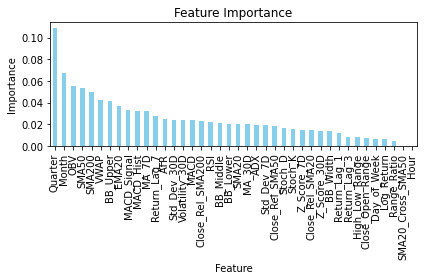

Top 10 features:
        Feature  Importance
22      Quarter    0.108644
20        Month    0.067541
21          OBV    0.055658
31        SMA50    0.053046
29       SMA200    0.049799
36         VWAP    0.042264
4      BB_Upper    0.041795
11        EMA20    0.037151
17  MACD_Signal    0.032970
16    MACD_Hist    0.032362
Generating predictions...
Generating trading signals...
Generated 7 buy signals, 1 sell signals, 18 holds
Backtesting strategy...
Calculating performance metrics...

Performance Metrics:
Total Return: -0.0201
Market Return: 0.0098
Annual Return: -0.2657
Annual Market Return: 0.1601
Annual Volatility: 0.6408
Sharpe Ratio: -0.4146
Max Drawdown: -0.1141
Win Rate: 0.4400
Profit Factor: 0.9753
Number of Trades: 5.0000

Plotting results...


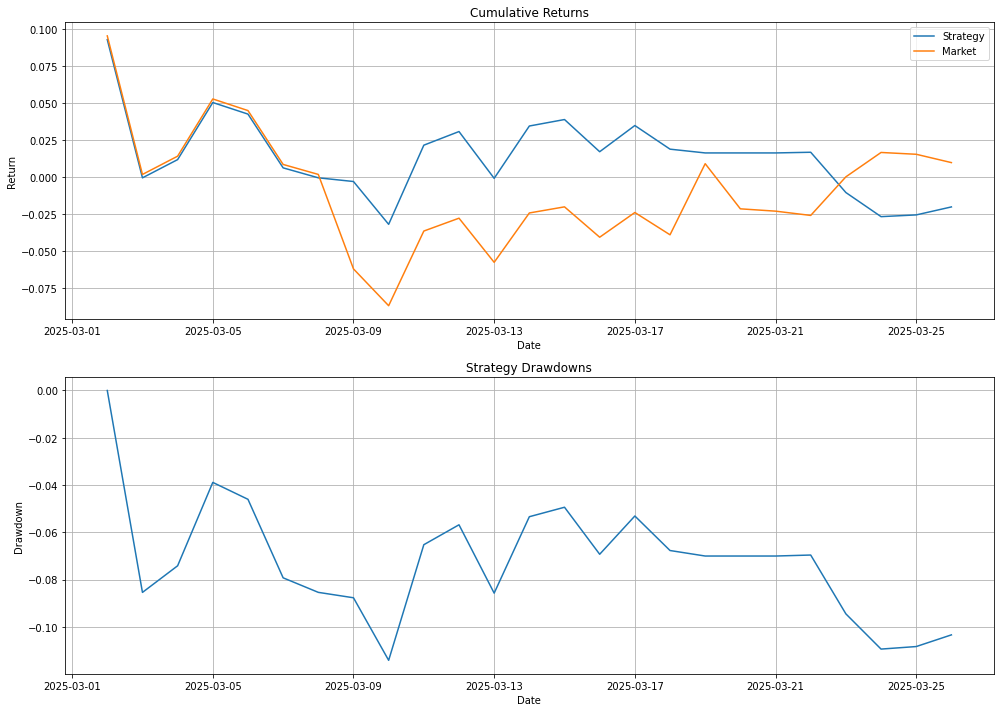

In [111]:
# Example usage
if __name__ == "__main__":
    model, backtest_results, metrics = main()